# Apartment Hunting on Craigslist

## Using linear regression to predict rental prices in San Francisco

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Data Import & Setup

In [2]:
sf = pd.read_csv('data_files/sf_clean.csv')

# Reformatting hood_district names
sf['hood_district'] = sf['hood_district'].astype(int)
sf['hood_district'] = sf['hood_district'].astype(str)

To improve model accuracy, I'm limiting the scope of the model to rentals under $6,000 per month

In [3]:
sf = sf[sf['price'] < 6000]

Converting Laundry and Parking to ordinal variables

In [4]:
laundry_dict = {'(a) in-unit': 2, 
               '(b) on-site': 1,
               '(c) no laundry': 0}

sf = sf.replace({'laundry': laundry_dict})

In [5]:
parking_dict = {'(a) valet': 3, 
               '(b) protected': 2,
               '(c) off-street': 1,
               '(d) no parking': 0}

sf = sf.replace({'parking': parking_dict})

Simplifying the Pets feature to a categorical variable (pets allowed or not).

In [6]:
pets_dict = {'(a) both': 1, 
            '(b) dogs': 1,
            '(c) cats': 1,
            '(d) no pets': 0}

sf = sf.replace({'pets': pets_dict})

Housing type (apartment, duplex, or single residence) has shown to be a weak feature in this model. 

In [7]:
sf = sf.drop(['housing_type'], axis=1)

Creating dummy variables for the last categorical feature: neighborhood districts

In [8]:
sf = pd.get_dummies(sf)
sf = sf.drop(['hood_district_10'], axis=1)

## Train / Test Split

Setting up train/test split to evaluate the final model's performance. 

In [9]:
X, y = sf.drop('price',axis=1), sf['price']

# Training versus Test Data
# hold out 20% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Training versus Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=4)

## Polynomial Features Set Up

In [10]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
    
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

In [11]:
# Scaling for Ridge & Lasso 
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_val_scaled = scaler.transform(X_val_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Regularization

## Lasso

Providing the Lasso Cross Validation method a series of alphas to test and pick the best one.

In [12]:
alphavec = 10**np.linspace(-2,1,10000)

lasso_model = LassoCV(alphas=alphavec, cv=3).fit(X_train_scaled, y_train)

In [13]:
las_alpha = lasso_model.alpha_
las_alpha

6.1699128249171915

In [14]:
las = Lasso(alpha=las_alpha)

las.fit(X_train_scaled, y_train)
print(f'Lasso Regression train R^2: {las.score(X_train_scaled, y_train):.5f}')
print(f'Lasso Regression val R^2: {las.score(X_val_scaled, y_val):.5f}')
print("")
print(f'Lasso Regression RMSE (train): {mean_squared_error(y_train, las.predict(X_train_scaled), squared=False):.5f}')
print(f'Lasso Regression RMSE (val): {mean_squared_error(y_val, las.predict(X_val_scaled), squared=False):.5f}')

Lasso Regression train R^2: 0.79802
Lasso Regression val R^2: 0.78779

Lasso Regression RMSE (train): 453.69726
Lasso Regression RMSE (val): 534.17586


Scoring high on both training and validation R^2 and RMSE metrics. 

## Ridge

Again, providing an series of alphas for the Ridge Cross Validation method to evaluate and pick the best one.

In [15]:
alphavec = 10**np.linspace(-2,2,500)

ridge_model = RidgeCV(alphas=alphavec, cv=3)
ridge_model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.01862899e-02, 1.03760502e-02, 1.05693455e-02,
       1.07662418e-02, 1.09668060e-02, 1.11711065e-02, 1.13792129e-02,
       1.15911962e-02, 1.18071285e-02, 1.20270833e-02, 1.22511358e-02,
       1.24793621e-02, 1.27118400e-02, 1.29486487e-02, 1.31898690e-02,
       1.34355829e-02, 1.36858742e-02, 1.39408283e-02, 1.42005318e-02,
       1.44650734e-02, 1.47345431e-0...
       6.54080591e+01, 6.66265452e+01, 6.78677305e+01, 6.91320378e+01,
       7.04198979e+01, 7.17317494e+01, 7.30680395e+01, 7.44292233e+01,
       7.58157646e+01, 7.72281357e+01, 7.86668179e+01, 8.01323013e+01,
       8.16250851e+01, 8.31456781e+01, 8.46945981e+01, 8.62723729e+01,
       8.78795401e+01, 8.95166472e+01, 9.11842520e+01, 9.28829225e+01,
       9.46132376e+01, 9.63757866e+01, 9.81711702e+01, 1.00000000e+02]),
        cv=3)

In [16]:
rid_alpha = ridge_model.alpha_
rid_alpha

7.830465404301183

In [17]:
rid = Ridge(alpha=rid_alpha)

rid.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y_train):.5f}')
print(f'Ridge Regression val R^2: {rid.score(X_val_scaled, y_val):.5f}')
print("")
print(f'Ridge Regression RMSE (train): {mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False):.5f}')
print(f'Ridge Regression RMSE (val): {mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False):.5f}')

Ridge Regression train R^2: 0.81330
Ridge Regression val R^2: 0.78622

Ridge Regression RMSE (train): 436.19833
Ridge Regression RMSE (val): 536.14653


Ridge regularization scoring very high as well. 

This is too close to call based on these splits. I'll set up a cross validation process using KFolds to evaluate each model over several runs and see if a clear winner emerges. 

## Ridge versus Lasso Evaluation

### Using KFolds for Cross Validation

In [18]:
kf = KFold(n_splits=3, shuffle=True, random_state = 12)

cv_rid_train_r2s, cv_las_train_r2s = [], []
cv_rid_val_r2s, cv_las_val_r2s = [], []

rid_rmses_train, las_rmses_train = [], []
rid_rmses_val, las_rmses_val = [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # Set up poly features
    poly = PolynomialFeatures(degree=2, interaction_only=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Scaling for Ridge & Lasso 
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_val_scaled = scaler.transform(X_val_poly)
    
    # Lasso
    las = Lasso(alpha=las_alpha)
    las.fit(X_train_scaled, y_train)
    
    cv_las_train_r2s.append(las.score(X_train_scaled, y_train))
    cv_las_val_r2s.append(las.score(X_val_scaled, y_val))
    las_rmses_train.append(mean_squared_error(y_train, las.predict(X_train_scaled), squared=False))
    las_rmses_val.append(mean_squared_error(y_val, las.predict(X_val_scaled), squared=False))
    
    # Ridge
    rid = Ridge(alpha=rid_alpha)
    rid.fit(X_train_scaled, y_train)
    
    cv_rid_train_r2s.append(rid.score(X_train_scaled, y_train))
    cv_rid_val_r2s.append(rid.score(X_val_scaled, y_val))
    rid_rmses_train.append(mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False))
    rid_rmses_val.append(mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False))

# Summary output

print("Ridge")
print(f'Ridge mean cv r^2 (TRAIN): {np.mean(cv_rid_train_r2s):.5f} +- {np.std(cv_rid_train_r2s):.5f}')
print(f'Ridge mean cv r^2 (VAL): {np.mean(cv_rid_val_r2s):.5f} +- {np.std(cv_rid_val_r2s):.5f}')
print(f'Ridge mean RMSE (TRAIN): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print(f'Ridge mean RMSE (VAL): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print('')
print("Lasso")
print(f'Lasso mean cv r^2 (TRAIN): {np.mean(cv_las_train_r2s):.5f} +- {np.std(cv_las_train_r2s):.5f}')
print(f'Lasso mean cv r^2 (VAL): {np.mean(cv_las_val_r2s):.5f} +- {np.std(cv_las_val_r2s):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_train):.5f} +- {np.std(las_rmses_train):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_val):.5f} +- {np.std(las_rmses_val):.5f}')    

Ridge
Ridge mean cv r^2 (TRAIN): 0.81876 +- 0.00649
Ridge mean cv r^2 (VAL): 0.76399 +- 0.00592
Ridge mean RMSE (TRAIN): 443.24502 +- 6.960
Ridge mean RMSE (VAL): 443.24502 +- 6.960

Lasso
Lasso mean cv r^2 (TRAIN): 0.80456 +- 0.00427
Lasso mean cv r^2 (VAL): 0.76630 +- 0.00219
Lasso mean RMSE (VAL): 460.32578 +- 4.06590
Lasso mean RMSE (VAL): 502.91010 +- 7.85106


The consistency of the Ridge regularized model makes it a compelling choice to move forward.

### Coefficients

Coefficients of both models available for evaluation.

In [19]:
rid_coefs = rid.coef_
las_coefs = las.coef_
features = sf.columns[1:]

coef_data = {'Features': poly.get_feature_names(X.columns),
             'Ridge': rid_coefs,
             'Lasso': las_coefs}

coef_df = pd.DataFrame(coef_data)

In [20]:
coef_df.head(10)

,Features,Ridge,Lasso
0,1,0.000000,0.000000
1,sqft,461.300104,494.635534
2,beds,336.388960,278.829942
3,bath,75.581774,0.000000
4,laundry,-50.427037,-0.000000
5,pets,-27.857723,0.000000
6,parking,-173.334140,-0.000000
7,hood_district_1,27.601505,1.894155
8,hood_district_2,7.514400,0.000000
9,hood_district_3,5.660664,-0.000000


In [21]:
#coef_df[:50]

In [22]:
#coef_df[50:100]

In [23]:
#coef_df[100:]

# Moving Forward with Ridge Regularization Model

## Full train and test

In [24]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
    
X_train_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

# Scaling for Ridge & Lasso 
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [25]:
rid = Ridge(alpha=rid_alpha)
rid.fit(X_train_scaled, y)

Ridge(alpha=7.830465404301183)

## Results

In [26]:
print("Ridge - training score: ", rid.score(X_train_scaled, y))
print("Rige - test score: ", rid.score(X_test_scaled, y_test))
print("")
print("RMSE - training: ", mean_squared_error(y, rid.predict(X_train_scaled), squared=False))
print("RMSE - test: ", mean_squared_error(y_test, rid.predict(X_test_scaled), squared=False))
print("")
print("MAE - training: ", np.mean(np.abs(rid.predict(X_train_scaled) - y)))
print("MAE - test: ", np.mean(np.abs(rid.predict(X_test_scaled) - y_test)))

Ridge - training score:  0.8126102806703003
Rige - test score:  0.7654766724734549

RMSE - training:  450.9562073553731
RMSE - test:  477.17411020645665

MAE - training:  341.23389455873496
MAE - test:  366.25041367614966


## Charts

### Actual versus Predicted

In [27]:
rid_predict = rid.predict(X_test_scaled)

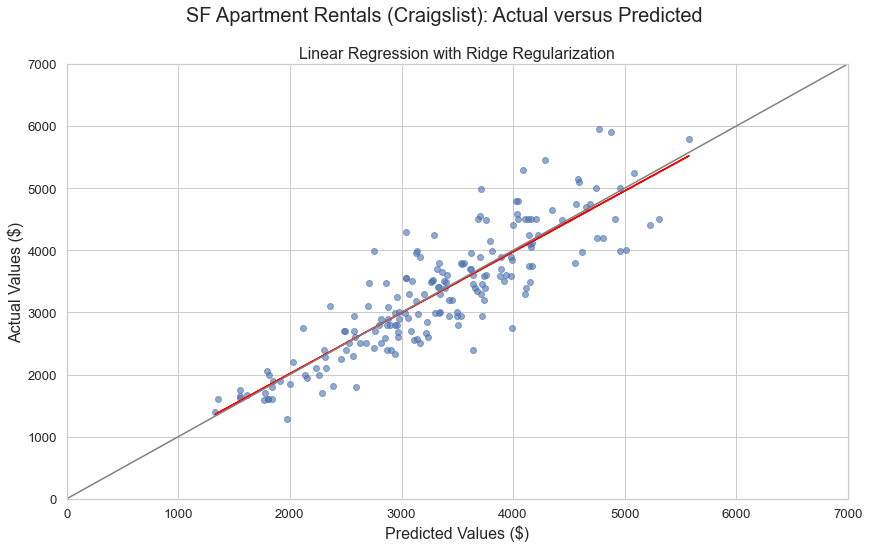

In [32]:
plt.figure(figsize=(14, 8))
plt.scatter(rid_predict, y_test, alpha=.6) 

z = np.polyfit(rid_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(rid_predict, p(rid_predict), 'm-', color='red')
plt.plot(np.linspace(0,7000,1000), np.linspace(0,7000,1000), color='grey')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.suptitle('SF Apartment Rentals (Craigslist): Actual versus Predicted', fontsize=20, fontname='Arial')
plt.title('Linear Regression with Ridge Regularization', fontsize=16, fontname='Arial')
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Actual Values ($)', fontsize=16, fontname='Arial');

#plt.savefig('img/ridge_actual_predicted.png')

### Residuals Plot

In [29]:
rid_residual = (y_test - rid_predict)

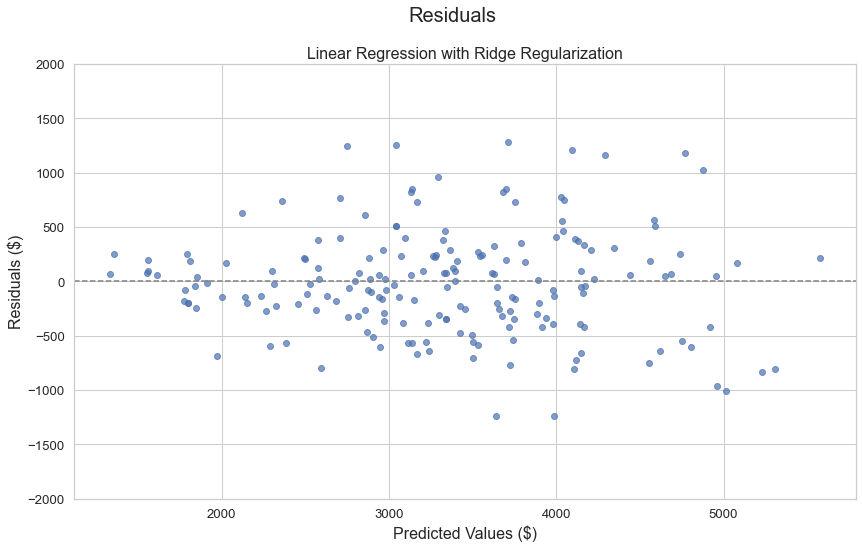

In [33]:
plt.figure(figsize=(14, 8))
plt.scatter(rid_predict, rid_residual, alpha=.7)   

plt.axhline(0, linestyle='--', color='grey')
plt.suptitle('Residuals', fontsize=20, fontname='Arial')
plt.title('Linear Regression with Ridge Regularization', fontsize=16, fontname='Arial')
plt.ylim(-2000, 2000)
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Residuals ($)', fontsize=16, fontname='Arial');

#plt.savefig('img/ridge_residuals.png')

# Appendix

## Distribution of Rental Prices in Sample

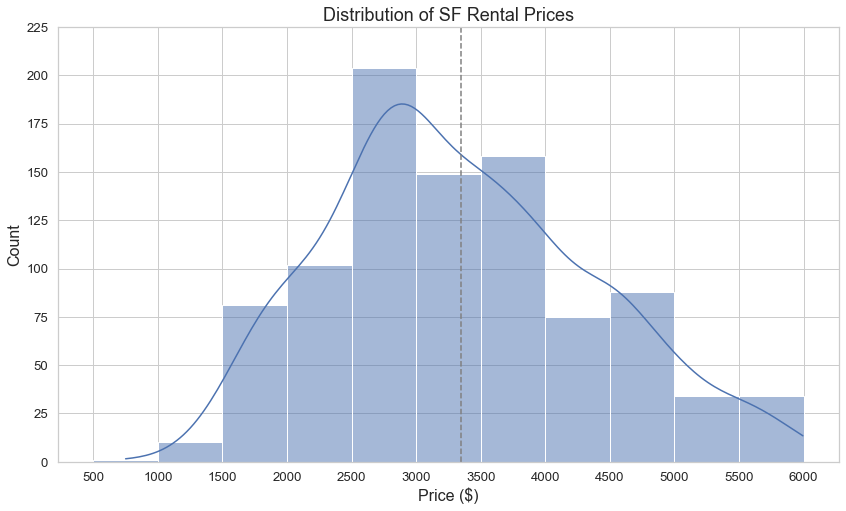

In [31]:
plt.figure(figsize=(14, 8))
ax_actual = sns.histplot(sf.price, kde=True, bins=(list(range(500, 6001, 500))))
plt.axvline(sf.price.mean(), linestyle='--', color='grey')
#ax_predict = sns.histplot(rid_predict, kde=True)
ax_actual.set_title('Distribution of SF Rental Prices', fontname='Arial', fontsize=18)
ax_actual.set_xlabel('Price ($)', fontname='Arial', fontsize=16)
ax_actual.set_ylabel('Count', fontname='Arial', fontsize=16)
ax_actual.set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
ax_actual.set_xticks(list(range(500, 6001, 500)))
ax_actual.set_xticklabels(list(range(500, 6001, 500)));

#plt.savefig('img/price_distribution.png');